# Chest XRay classification for Pneumonia detection 

In [59]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.transforms import ToTensor
%matplotlib inline

## Data Preparation and data augmentation

The data directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. The directory consists of three folders : train, val and test containing xray chest images of patients with pneumonia and without pneumonia.

In [60]:
DATA_DIR = '../input/chest-xray-pneumonia/chest_xray'
TRAIN_DIR = DATA_DIR + '/train'                        
TEST_DIR = DATA_DIR + '/val'                        
VAL_DIR = DATA_DIR + '/test'

classes = os.listdir(TRAIN_DIR)
print(classes)

['PNEUMONIA', 'NORMAL']


We can define the transformations that will allow to transform the images to tensors compatible with pytorch framework but also to augment the data set in the case of teh training dataset. This will allow to have more realistic data to train our model.

In [61]:
train_transform = T.Compose([
        T.Resize((224,224)),
        T.RandomRotation(5),
        T.ToTensor()])

val_transform = T.Compose([
        T.Resize((224,224)),  
        T.ToTensor()])

ImageFolder method allows us to create the data set.

In [62]:
train_ds = ImageFolder(TRAIN_DIR, transform=train_transform)
test_ds = ImageFolder(TEST_DIR, transform=val_transform)
val_ds = ImageFolder(VAL_DIR, transform=val_transform)

print(len(train_ds))
print(len(val_ds))

5216
624


Thee training folder contains 5216 pictures each of them having a resolution of 216 by 216 pixels. Loading the whole dataset in the RAM is not feasible. So we use a data loader that will leads to the loading of the images by random groups of fixed number of images, called 'batch'.
We also manually choose the seed for the pseudo random numbers generator for the repetability of our notebook results. 

In [63]:
torch.manual_seed(10)
batch_size = 32

In [64]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

We can now take a look at a single element of  our data set. We plot the image thanks to the widely used Pandas  library and we also print thhe label ofthe image (Pneumonia or normal).

torch.Size([3, 224, 224])
Label (numeric): 0
Label (textual): PNEUMONIA


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

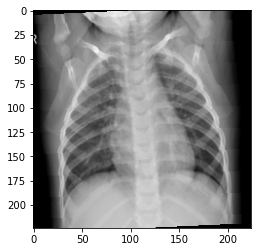

In [65]:
img, label = train_ds[666]
plt.imshow(img.permute((1, 2, 0)))
print(img.shape)
print('Label (numeric):', label)
print('Label (textual):', classes[label])
img

The following function plots a batch of images as given by the dataloader.

In [66]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

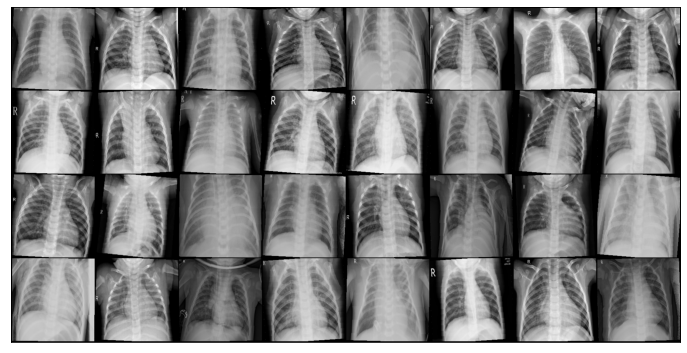

In [67]:
show_batch(train_dl)

In [68]:
!pip install jovian --upgrade -q
import jovian

In [69]:
jovian.commit(project="XRay classification for Pneumonia detection")

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/m-chemseddine/XRay classification for Pneumonia detection


<IPython.core.display.Javascript object>

## Using a GPU
PyTorch famework can fully use GPUs to accelerate the calculations. We define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to detect the presence of a GPU (and the sotware environment needed : cuda) and to move our model & data to the GPU if everything is ok.

In [70]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [71]:
device = get_default_device()
device

device(type='cuda')

In [72]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Models definition

We defined the data set and loaded it in the appropriate device (CPU or GPU). We can now define the model that we will train at detecting Pneumonia on XRAYs.

### Metrics

We first define the accuracy as a performance metric of our model to follow its evolution during the training.

In [73]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Class base for models

XRayClassificationBase class is the 'skeleton' of the models we are going to use. It includes the basic methods necessary to train a model.

In [74]:
class XRayClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

### Models list

After defining the basic methods of a model we are goign now to define explicit models by extending the XRayClassificationBase class. For this project we are going to define 3 Resnet models variations to compare how the Resnet neural network evolved.

In [97]:
class PneumoniaXRayModelResNet18(XRayClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet18(pretrained=True)
        # Replace last layer1
        self.network.fc = nn.Linear(512, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True


In [98]:
class PneumoniaXRayModelResNet34(XRayClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        # Replace last layer1
        self.network.fc = nn.Linear(512, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [99]:
class PneumoniaXRayModelResNet50(XRayClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        # Replace last layer1
        self.network.fc = nn.Linear(2048, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [100]:
class PneumoniaXRayModelResNet101(XRayClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet101(pretrained=True)
        # Replace last layer1
        self.network.fc = nn.Linear(2048, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [101]:
class PneumoniaXRayModelResNet152(XRayClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet152(pretrained=True)
        # Replace last layer1
        self.network.fc = nn.Linear(2048, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In order to run the training of our model we define a couple of functions.
The evaluate function will evaluate the accuracy of the model before training and gives us a reference initial value of the model accuracy. The get_lr function returns the learning rate value. The fit_one_cycle is the core of the model training as it leads to one epoch training of the model.

In [102]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Training the models

We can now define a first model and load it in the appropriate device.

In [103]:
model1 = to_device(PneumoniaXRayModelResNet18(), device)
model1

PneumoniaXRayModelResNet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [104]:
model2 = to_device(PneumoniaXRayModelResNet34(), device)
model2

PneumoniaXRayModelResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [105]:
model3 = to_device(PneumoniaXRayModelResNet50(), device)
model3

PneumoniaXRayModelResNet50(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

In [106]:
model4 = to_device(PneumoniaXRayModelResNet101(), device)
model4

PneumoniaXRayModelResNet101(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [107]:
model5 = to_device(PneumoniaXRayModelResNet152(), device)
model5

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


PneumoniaXRayModelResNet152(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

We evaluate the accuracy of the model before the learning.

In [108]:
history = [evaluate(model1, val_dl)]
history

[{'val_loss': 0.695423424243927, 'val_acc': 0.4885416626930237}]

In [109]:
history = [evaluate(model2, val_dl)]
history

[{'val_loss': 0.7178827524185181, 'val_acc': 0.36250001192092896}]

In [110]:
history = [evaluate(model3, val_dl)]
history

[{'val_loss': 0.7062357664108276, 'val_acc': 0.37187498807907104}]

In [111]:
history = [evaluate(model4, val_dl)]
history

[{'val_loss': 0.6996053457260132, 'val_acc': 0.4098958373069763}]

In [112]:
history = [evaluate(model5, val_dl)]
history

[{'val_loss': 0.6883857846260071, 'val_acc': 0.5604166388511658}]

It is possible to use a pretrained model for our xray classification and train only the last layer to accelerate the training. For this purpose we call the freeze method of our model to freeze all the layers but the last.

In [113]:
model1.freeze()
model2.freeze()
model3.freeze()
model4.freeze()
model5.freeze()

Let's defien now the learning parameters.

In [114]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

And we can finally run the training on 10 epochs.

In [115]:
%%time
history1 = fit_one_cycle(epochs, max_lr, model1, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

KeyboardInterrupt: 

In [116]:
torch.save(model.state_dict(), 'XRAYs_model1.pth')

#### Plotting scores

In [117]:
def plot_lrs(history1):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [118]:
def plot_losses(history1):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [119]:
plot_losses(history1)

NameError: name 'history1' is not defined

In [ ]:
plot_lrs(history1)

In [ ]:
jovian.commit(project="XRay classification for Pneumonia detection")

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/m-chemseddine/XRay classification for Pneumonia detection


<IPython.core.display.Javascript object>

## Testing

In [ ]:
def predict_image(img, model1):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [ ]:
test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)
results = evaluate(model1, test_dl)
results

improvements possible
#TODO        T.RandomCrop(95, padding=10, padding_mode='reflect'),
#TODO        T.Grayscale(num_output_channels=3),
#TODO       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])